In [1]:
from PIL import Image
import numpy as np

from sklearn import linear_model
from scipy.optimize import minimize

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def load_image( infilename ) :
    img = Image.open(infilename)
    img.load()
    data = np.asarray( img, dtype="int32" )
    return data

def save_image( npdata, outfilename ) :
    img = Image.fromarray( np.asarray( np.clip(npdata,0,255), dtype="uint8"), "L" )
    img.save( outfilename )

In [3]:
image_arr = load_image("snap_gray.png")

In [4]:
image_arr.shape

(216, 384, 2)

In [5]:
x_coord = []
y_coord = []
for i,row in enumerate(image_arr):
    for j, col in enumerate(row):
        if (col[0] > 0):
            x_coord.append(i)
            y_coord.append(j)
            
x_coord = np.array(x_coord)
y_coord = np.array(y_coord)

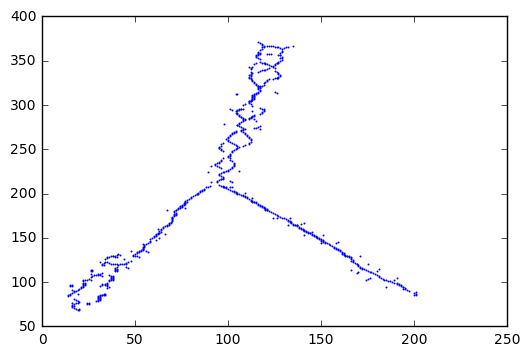

In [7]:
plt.scatter(x_coord, y_coord, lw=0, s=2)
plt.show()

## Expectation Maximisation Approach

In [13]:
# TODO:
# Note to Aditi, I have guessed at these from the full image with the session boundaries.
# Have you run code that picks up the correct coordinates and labels the biomes correctly?

biomes = [
    ("biome1", 10, 122),
    ("biome2", 5,  211),
    ("biome3", 30, 315),
    ("biome4", 192, 70),
    ("biome5", 198, 178),
    ("biome6", 160, 270),
    ("waterfall",110,325)
]

I am still iterating with how this code should work but we'll extract the following into a source file at some stage.|

In [24]:
# helper functions
def f(yi, mui, sigma2, **kwargs):
    value = np.exp(-((yi-mui)**2)/(2*sigma2))/np.sqrt(2*np.pi*sigma2)
    return value

def T(j, i, params, **kwargs):
    terms = [params['tau'][k] * f(params['y'][i], params['X'][i].dot(params['mu'][k]), params['sigma2'][k]) for k in range(params['K'])]
    return terms[j]/np.sum(terms)

def T_tplus1(j, params, **kwargs):
    return params['denom'][j]/len(params['y'])

def U_tplus1(j, params, **kwargs):
    x = params['X']
    xt = params['X'].T
    w = params['T'][:,j].reshape(-1,1)
    y = params['y']
    weighted_num = np.linalg.pinv(xt.dot(w*x)).dot(xt*w.T).dot(y)
    return weighted_num

def Sigma_tplus1(j, params, **kwargs):
    weighted_num = np.sum([params['T'][i,j] * np.square(params['y'][i] - params['X'][i].dot(params['mu'][j])) for i in params['N']])
    denom = params['denom'][j]
    return weighted_num/denom

def default_stop(old_state, params):
    return params['count'] <= 20
    
class WaterPath:
    def __init__(self, X, y, biomes, **kwargs):
        self.X = X
        self.y = y
        self.biomes = biomes
        # array of centroids of the streams - This is probably the log coordinates
        self.centroid = kwargs['centroid'] if 'centroid' in kwargs else None;
        self.K = kwargs['K'] if 'K' in kwargs else 3; # number of distinct streams
        self.N = kwargs['N'] if 'N' in kwargs else range(len(y)); # number of datapoints
    
    def initialise_params(self, log_position, num_streams):
        # TODO: Some fancy stuff to init params here
        # Note to Aditi. EM is susceptible to bad initialisations (as it might get stuck at other optima). A good 
        # initialisation of the algorithm is going to be important. We can use the log positions and the fact that 
        # we know the waterfall is always running to assist with this.
        
        mu = np.array([[0,200],[5,-300],[-2,400]])
        tau = [0.33,0.34,0.33]
        sigma = [15,15,15]
        
        self.X = np.concatenate([self.X, np.array([[self.centroid[0], 1]])])
        self.y = np.concatenate([self.y, [self.centroid[1]]])
        
        params = {
            'tau' : tau,
            'mu' : mu,
            'sigma2' : sigma,
            'X' : self.X,
            'y' : self.y,
            'count': 0,
            'T': np.zeros_like(self.N),
            'K': self.K,
            'N': range(len(self.y))
        }
        
        return params
    
    # Run EM algorithm
    def EM(self, params, stopping_condition=default_stop):
        
        old_state = None
        
        while stopping_condition(old_state, params):
            old_state = params
            
            params['T'] = np.array([[T(j,i,params) for j in range(self.K)] for i in params['N']])

            # clamp the algorithm to pass through the centroid
            params['T'][-1] = np.array([100,100,100])

            params['denom'] = np.sum(params['T'], axis=0)

            tp1 = [T_tplus1(j, params) for j in range(params['K'])]
            up1 = [U_tplus1(j, params) for j in range(params['K'])]

            params['mu'] = up1
            sp1 = [Sigma_tplus1(j, params) for j in range(params['K'])]

            params['tau'] = tp1
            params['sigma2'] = sp1
            params['count'] += 1
            
        return params
    
    def get_biomes_associated_with_params(self, params):
        
        y = np.array([biome[2] for biome in self.biomes])
        X = np.array([[biome[1],1] for biome in self.biomes])
        
        selected_biome = []
        for mu, sigma2 in zip(params['mu'], params['sigma2']):
        
            selected_biome.append(np.argmax([
                        f(y[i], X[i].dot(mu), sigma2) for i in range(len(y))]))
            
        return [self.biomes[i] for i in selected_biome]
    
    def print_waterflow(self, params):
        
        selected_biomes = self.get_biomes_associated_with_params(params)
        
        # start with the waterfall
        for i, (mu, sigma2) in enumerate(zip(params['mu'], params['sigma2'])):
            
            print(selected_biomes[i])
            print("Edge1: {}, Edge2: {}".format(self.centroid, [selected_biomes[i][1], selected_biomes[i][2]]))
            
            if selected_biomes[i][0] == 'waterfall':
                print("Incoming: True")
                print("Percentage flow: {}".format(params['tau'][i]*100))
                
            else:
                print("Incoming: False")
                print("Percentage of flow: {}".format(params['tau'][i]*100))
                
            print()
        

We can use the above class to detect the water paths.

In [25]:
X = np.concatenate([x_coord.reshape(-1,1), np.ones_like(x_coord.reshape(-1,1))], axis=1)
water_path = WaterPath(X, y_coord, biomes, centroid=[95,210])
params = water_path.initialise_params(None, None)
params = water_path.EM(params)

In [26]:
s_b = water_path.get_biomes_associated_with_params(params)
water_path.print_waterflow(params)

('biome1', 10, 122)
Edge1: [95, 210], Edge2: [10, 122]
Incoming: False
Percentage of flow: 50.542572488970116

('waterfall', 110, 325)
Edge1: [95, 210], Edge2: [110, 325]
Incoming: True
Percentage flow: 48.22837117539683

('biome4', 192, 70)
Edge1: [95, 210], Edge2: [192, 70]
Incoming: False
Percentage of flow: 39.3182283101554



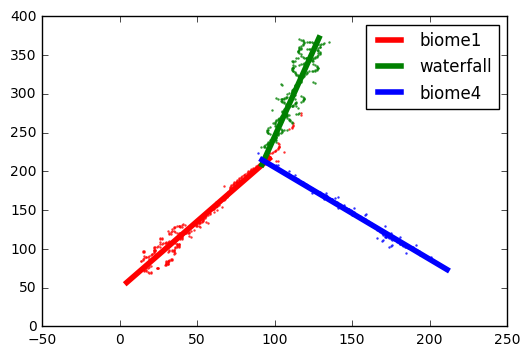

In [20]:
xs = np.linspace(0,225)

lines = [[], [], []]

for x in xs:
    for i, l in enumerate(params['mu']):
        y = l[1] + l[0] * x
        
        if (((x >= water_path.centroid[0]-5) and (x <= s_b[i][1] + 20)) or 
            ((x < water_path.centroid[0]+5) and (x > s_b[i][1] - 10) )):
            
            lines[i].append([x,y])

colors = ['r', 'g', 'b']
selection = np.argmax(params['T'], axis=1)

lines = [np.array(l) for l in lines]


for i in range(3):
    plt.scatter(params['X'][:,0][selection == i], params['y'][selection == i], c = colors[i], lw=0, s=3, alpha=0.8)

    plt.plot(lines[i][:,0], lines[i][:,1], c = colors[i], lw=4, label=s_b[i][0])

plt.legend(loc='best')
plt.show()